***USED FOR ANALYSIS OF TRANSCRIPTION***

**TO DO** 

- Remove filler words and do csv analysis.
- Find which words come in as replacement and make graphs
- What to do with gaap and EBITDA

In [48]:
import os
from jiwer import wer, mer, wil, compute_measures
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import re
import pandas as pd
from rapidfuzz import fuzz, process
import random
import warnings
from pathlib import Path
from matplotlib.patches import Patch
from difflib import SequenceMatcher
import unicodedata


In [90]:
def is_latin_char(ch): # Check if a character is Latin or a digit to avoid foreign
    name = unicodedata.name(ch, '')
    return 'LATIN' in name or ch.isdigit() or ch.isspace()

def clean_and_tokenize(text):
    text = text.lower()

    # Protect decimals (e.g. 2.4 → 2__DOT__4)
    text = re.sub(r'(?<=\d)\.(?=\d)', '__DOT__', text)
    text = ''.join(ch for ch in text if is_latin_char(ch))
    # Restore decimals
    text = text.replace('__DOT__', '.')

    return text.split()
def read_txt_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().strip()

def get_transcript_variants(root_folder, suffixes):
    all_pairs = []
    for subdir in os.listdir(root_folder):
        full_path = os.path.join(root_folder, subdir)
        if os.path.isdir(full_path):
            files = os.listdir(full_path)
            gt_file = [f for f in files if f.endswith('.txt') and not any(f.endswith(suffix) for suffix in suffixes) and not f.endswith('_timing.txt')]
            if not gt_file:
                continue
            gt_path = os.path.join(full_path, gt_file[0])
            for suffix in suffixes:
                hyp_file = [f for f in files if f == f"{subdir}{suffix}"]
                if hyp_file:
                    hyp_path = os.path.join(full_path, hyp_file[0])
                    all_pairs.append((subdir, suffix, gt_path, hyp_path))
    return all_pairs

def compute_metrics(gt_text, hyp_text):
    measures = compute_measures(gt_text, hyp_text)
    return {
        "wer": measures['wer'],
        "mer": measures['mer'],
        "wil": measures['wil']
    }

def evaluate_folder_variants(base_folder, suffixes):
    results = []
    rows = []
    pairs = get_transcript_variants(base_folder, suffixes)

    for folder_name, suffix, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        gt_tokens = clean_and_tokenize(gt)
        hyp_tokens = clean_and_tokenize(hyp)
        gt_clean = ' '.join(gt_tokens)
        hyp_clean = ' '.join(hyp_tokens)
        metrics = compute_metrics(gt_clean, hyp_clean)

        results.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "gt_path": gt_path,
            "hyp_path": hyp_path,
            "gt_text": gt_clean,
            "hyp_text": hyp_clean,
            "gt_word_count": len(gt_tokens),
            "hyp_word_count": len(hyp_tokens)
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)

    # Total word count printout
    summary = df_paths.groupby("variant")[["gt_word_count", "hyp_word_count"]].sum()
    print(f"\n{base_folder} — Total word counts:")
    print(summary)

    return df_metrics, df_paths


variant_name_map = {
    '_Whisper.txt': 'whisper-small',
    '_Turbo_Whisper.txt': 'whisper-large-v3-turbo',
    '_openai_transcript.txt': 'GPT-4o mini Transcribe'
}

suffixes = ['_Whisper.txt', '_openai_transcript.txt', '_Turbo_Whisper.txt']
df_21, df_paths_21 = evaluate_folder_variants('Data/combined_21', suffixes)
print("Combined 21 summary:")
print(df_21.groupby("variant").describe())

df_22, df_paths_22 = evaluate_folder_variants('Data/combined_22', suffixes)
print("\nCombined 22 summary:")
print(df_22.groupby("variant").describe())


Data/combined_21 — Total word counts:
                        gt_word_count  hyp_word_count
variant                                              
GPT-4o mini Transcribe         362220          334842
whisper-large-v3-turbo         362220          341788
whisper-small                  362220          342800
Combined 21 summary:
                         wer                                          \
                       count      mean       std       min       25%   
variant                                                                
GPT-4o mini Transcribe  44.0  0.138838  0.039245  0.076688  0.112188   
whisper-large-v3-turbo  44.0  0.139690  0.039774  0.074037  0.116178   
whisper-small           44.0  0.165050  0.044107  0.108366  0.135530   

                                                       mer            ...  \
                             50%       75%       max count      mean  ...   
variant                                                               ...   
GPT-4o

In [50]:
percent_per_variant = (
    df_22.assign(over_50=df_22['wer'] > 0.5)
         .groupby("variant")['over_50']
         .mean() * 100
)

print("Percentage of files with WER > 50%:")
print(percent_per_variant.round(1))


Percentage of files with WER > 50%:
variant
GPT-4o mini Transcribe    2.4
whisper-large-v3-turbo    0.8
whisper-small             3.2
Name: over_50, dtype: float64


In [51]:
# Step 1: Combine all metrics and paths
df_all = pd.concat([df_21, df_22], ignore_index=True)
df_paths_all = pd.concat([df_paths_21, df_paths_22], ignore_index=True)
df_full = pd.merge(df_all, df_paths_all, on=['folder', 'variant'], how='left')

# Step 2: Compute average WER per folder
avg_wer_per_folder = (
    df_full.groupby("folder")['wer']
    .mean()
    .reset_index(name='avg_wer')
)

# Step 3: Get top 3 folders with highest average WER
top_3_folders = avg_wer_per_folder.nlargest(3, 'avg_wer')['folder'].tolist()

# Step 4: Get all rows for those top 3 folders
top_3_details = df_full[df_full['folder'].isin(top_3_folders)]

# Step 5: Print nicely
print("Top 3 folders with highest average WER across variants:\n")
for folder in top_3_folders:
    folder_df = top_3_details[top_3_details['folder'] == folder]
    avg = folder_df['wer'].mean()
    print(f"Folder: {folder} (Avg WER: {avg:.2f})")
    for _, row in folder_df.iterrows():
        print(f"  Variant: {row['variant']}")
        print(f"    WER: {row['wer']:.2f}")
        print(f"    GT Path: {row['gt_path']}")
        print(f"    Hyp Path: {row['hyp_path']}")
    print()


Top 3 folders with highest average WER across variants:

Folder: 4453076 (Avg WER: 0.73)
  Variant: whisper-small
    WER: 0.77
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_Whisper.txt
  Variant: GPT-4o mini Transcribe
    WER: 0.73
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_openai_transcript.txt
  Variant: whisper-large-v3-turbo
    WER: 0.69
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_Turbo_Whisper.txt

Folder: 4481766 (Avg WER: 0.50)
  Variant: whisper-small
    WER: 0.61
    GT Path: Data/combined_22\4481766\4481766.txt
    Hyp Path: Data/combined_22\4481766\4481766_Whisper.txt
  Variant: GPT-4o mini Transcribe
    WER: 0.41
    GT Path: Data/combined_22\4481766\4481766.txt
    Hyp Path: Data/combined_22\4481766\4481766_openai_transcript.txt
  Variant: whisper-large-v3-turbo
    WER: 0.47
    GT Path: Data/combined_22\4481766


=== WER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WER: 0.139
GPT-4o mini Transcribe         | Earnings22   → Mean WER: 0.191
whisper-large-v3-turbo         | Earnings21   → Mean WER: 0.140
whisper-large-v3-turbo         | Earnings22   → Mean WER: 0.193
whisper-small                  | Earnings21   → Mean WER: 0.165
whisper-small                  | Earnings22   → Mean WER: 0.227

=== MER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean MER: 0.137
GPT-4o mini Transcribe         | Earnings22   → Mean MER: 0.187
whisper-large-v3-turbo         | Earnings21   → Mean MER: 0.137
whisper-large-v3-turbo         | Earnings22   → Mean MER: 0.185
whisper-small                  | Earnings21   → Mean MER: 0.161
whisper-small                  | Earnings22   → Mean MER: 0.215

=== WIL Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WIL: 0.178
GPT-4o mini Transcribe         | Earnings22  

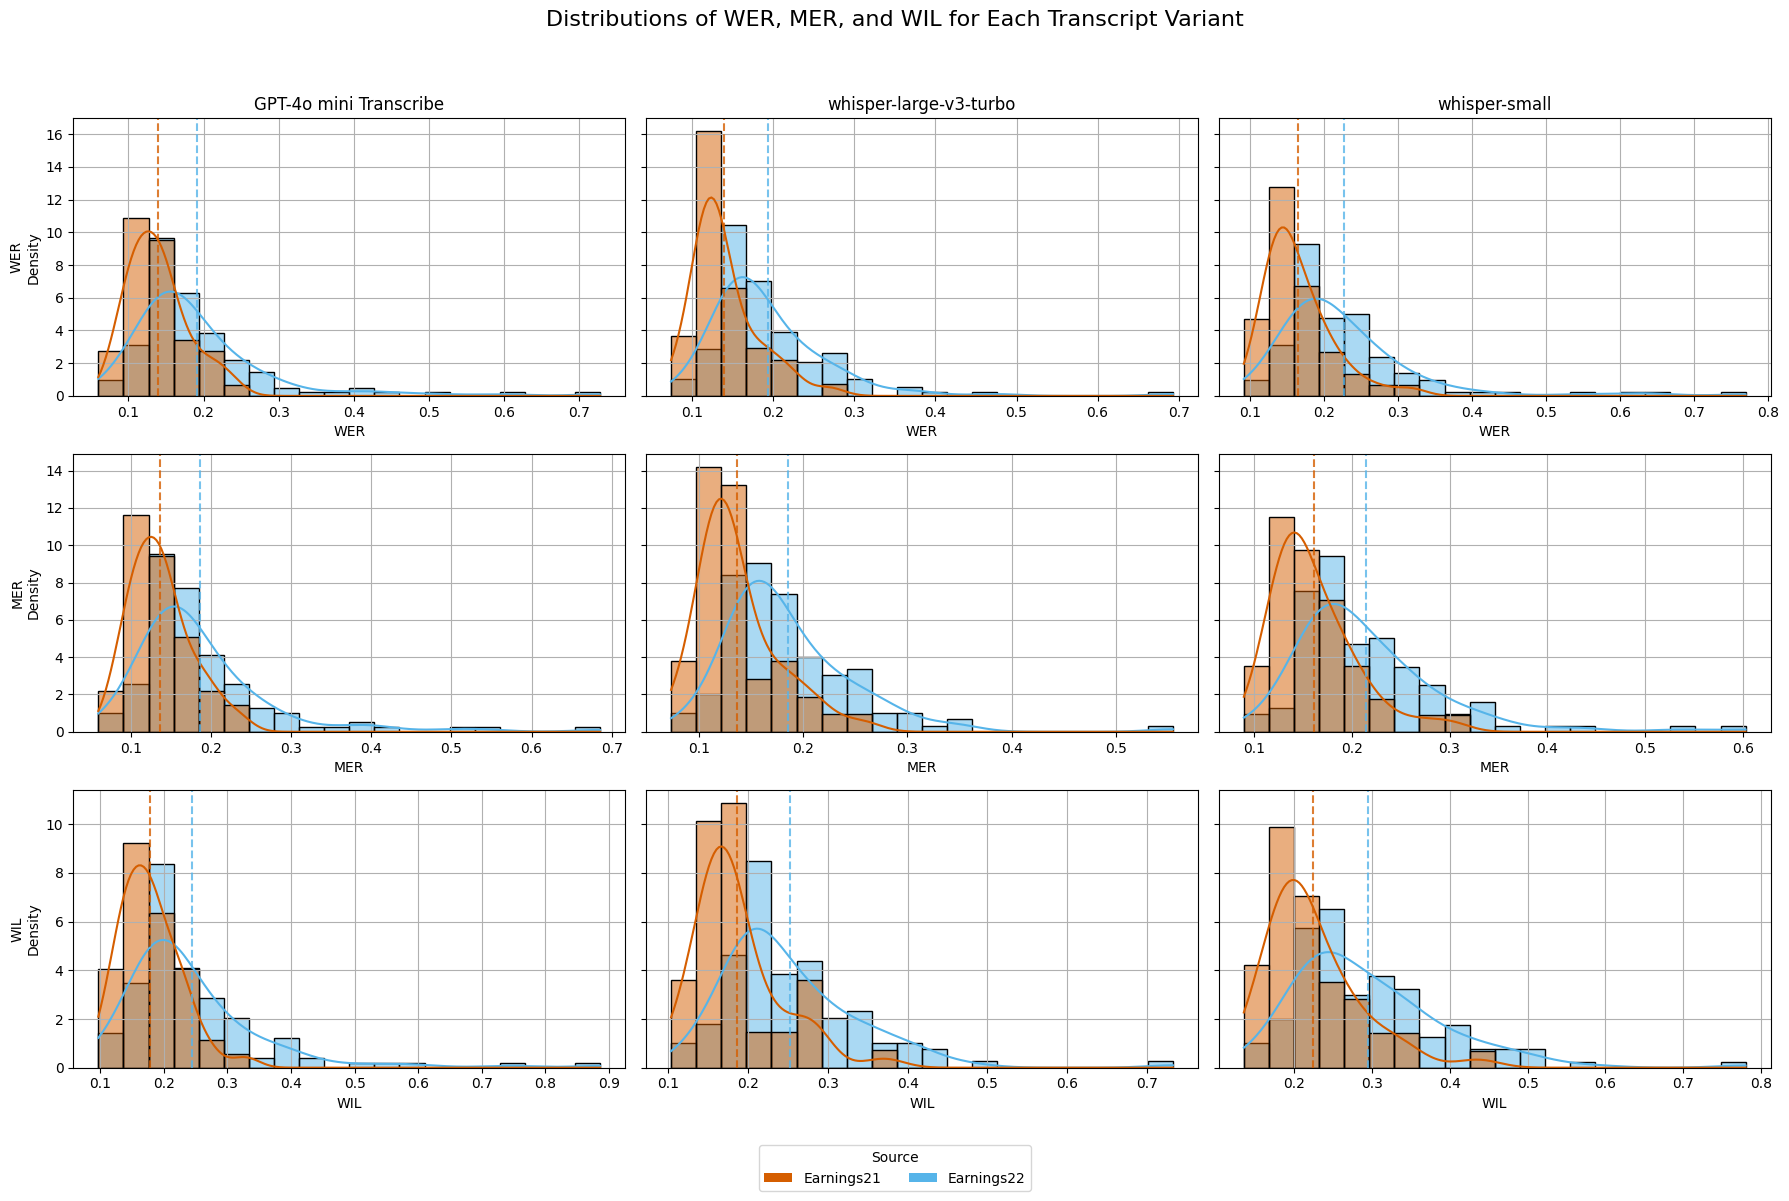

In [52]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# Add 'source' column and combine
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'
df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Melt for boxplot
df_melted = df_combined.melt(
    id_vars=['folder', 'source', 'variant'],
    value_vars=['wer', 'mer', 'wil'],
    var_name='metric',
    value_name='value'
)

palette = {
    "combined_21": "#D55E00",
    "combined_22": "#56B4E9"
}

legend_label_map = {
    "combined_21": "Earnings21",
    "combined_22": "Earnings22"
}

variants = sorted(df_combined['variant'].unique())
metrics = ['wer', 'mer', 'wil']

# === Combined 3x3 figure ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey='row')

for row, metric in enumerate(metrics):
    print(f"\n=== {metric.upper()} Means by Variant and Source ===")

    for col, variant in enumerate(variants):
        ax = axes[row][col]
        df_variant = df_combined[df_combined['variant'] == variant]

        # Histogram with KDE
        sns.histplot(
            data=df_variant,
            x=metric,
            hue='source',
            palette=palette,
            kde=True,
            bins=20,
            stat='density',
            common_norm=False,
            ax=ax,
            legend=False
        )

        # Add vertical mean lines and print
        for source in df_variant['source'].unique():
            source_df = df_variant[df_variant['source'] == source]
            mean_val = source_df[metric].mean()
            color = palette[source]

            # Print to console
            print(f"{variant:30} | {legend_label_map[source]:12} → Mean {metric.upper()}: {mean_val:.3f}")

            ax.axvline(mean_val, linestyle='--', color=color, linewidth=1.5, alpha=0.8)

        # Titles and labels
        if row == 0:
            ax.set_title(f"{variant}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{metric.upper()}\nDensity", fontsize=10)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(metric.upper())
        ax.grid(True)

# === Add shared legend with renamed labels ===
legend_elements = [
    Patch(facecolor=palette["combined_21"], label="Earnings21"),
    Patch(facecolor=palette["combined_22"], label="Earnings22")
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.01),
    frameon=True,
    title="Source"
)

fig.suptitle("Distributions of WER, MER, and WIL for Each Transcript Variant", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


I want to find filler words that are only in the ground truth but not the transcripts


C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

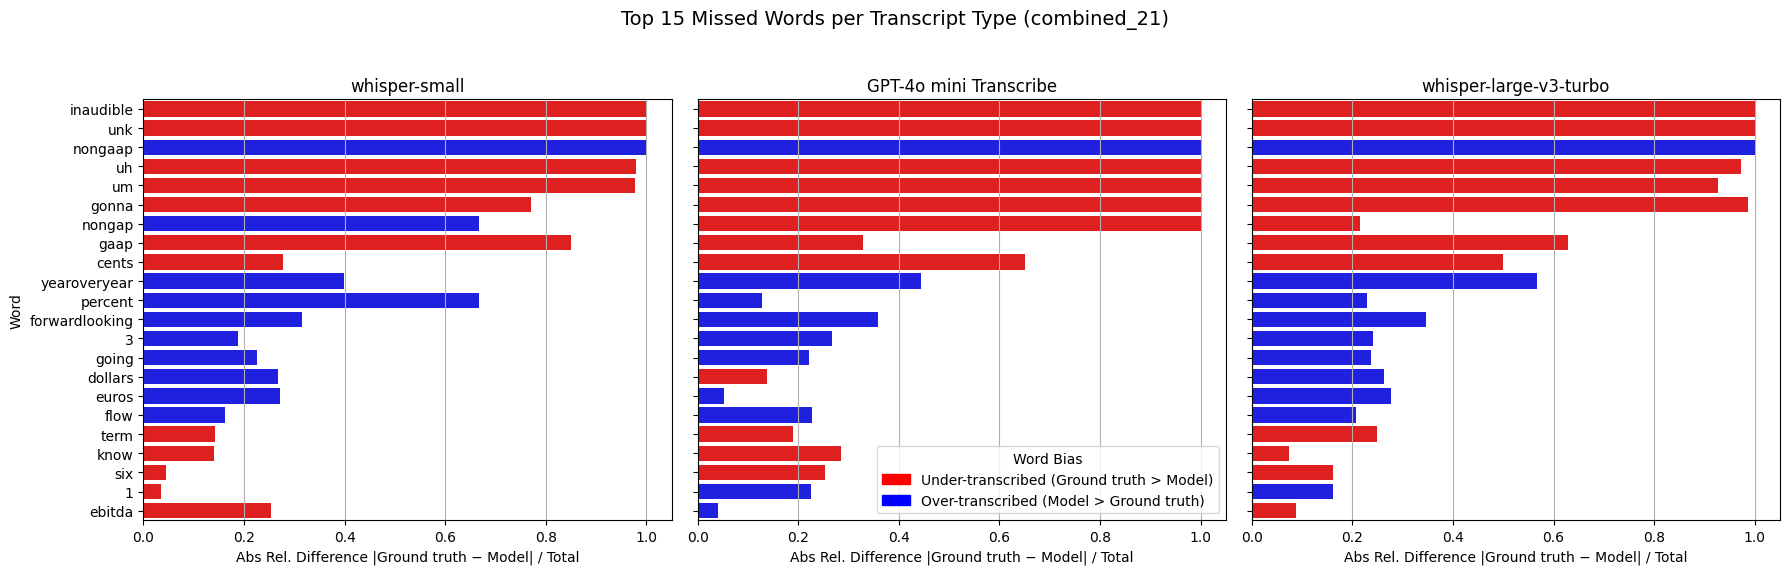

C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

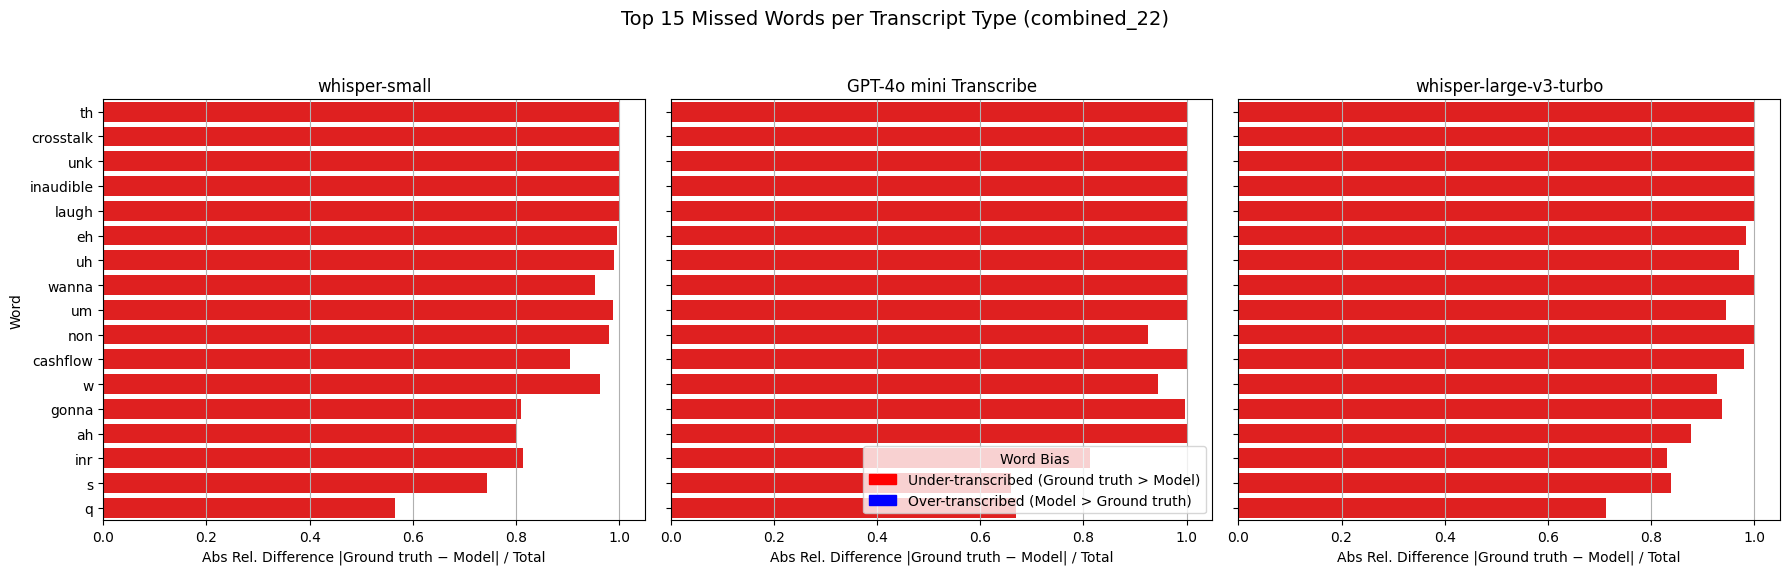

In [53]:
min_total = 100
def get_top_missed_words_by_variant(df_paths, label='', top_n=15, plot=True, filter_words=None):
    variants = df_paths['variant'].unique()
    fig, axes = plt.subplots(1, len(variants), figsize=(6 * len(variants), 6), sharey=True) if plot else (None, [None] * len(variants))
    if len(variants) == 1:
        axes = [axes]  

    all_top_words = []
    for i, (ax, variant) in enumerate(zip(axes, variants)):
        df_var = df_paths[df_paths['variant'] == variant]
        gt_words = []
        hyp_words = []

        for _, row in df_var.iterrows():
            gt_words += row['gt_text'].split()
            hyp_words += row['hyp_text'].split()

        gt_counter = Counter(gt_words)
        hyp_counter = Counter(hyp_words)
        all_words = set(gt_counter) | set(hyp_counter)

        data = []
        for word in all_words:
            gt_count = gt_counter[word]
            hyp_count = hyp_counter[word]
            total = gt_count + hyp_count
            color = 'red' if gt_count > hyp_count else 'blue'
            rel_diff = abs((gt_count - hyp_count)) / total
            data.append({
                'variant': variant,
                'word': word,
                'gt_count': gt_count,
                'hyp_count': hyp_count,
                'rel_diff': rel_diff,
                'total': total,
                'top' : False,
                'color': color
            })

        df_diff = pd.DataFrame(data)
        df_top = df_diff[df_diff['total'] > min_total].sort_values(by='rel_diff', ascending=False).head(top_n)
        df_diff['top'] = df_diff['word'].isin(df_top['word'])
        all_top_words.append(df_diff)
        if plot:
            if filter_words is not None:
                df_plot = df_diff[df_diff['word'].isin(filter_words)]
            else:
                df_plot = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)
            sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
            if i == 1:  # Only show legend on the middle plot
                legend_handles = [Patch(color='red', label='Under-transcribed (Ground truth > Model)'), Patch(color='blue', label='Over-transcribed (Model > Ground truth)')]
                ax.legend(handles=legend_handles, title='Word Bias', loc='lower right')
            ax.set_title(f"{variant}")
            ax.set_xlabel("Abs Rel. Difference |Ground truth − Model| / Total")
            ax.set_ylabel("Word")
            ax.grid(True, axis='x')

    if plot:
        plt.suptitle(f"Top {top_n} Missed Words per Transcript Type ({label})", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    return pd.concat(all_top_words, ignore_index=True)




# First run: collect all data (no plots)
df_all_21 = get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=False)
df_all_22 = get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=False)

top_words_21 = df_all_21[(df_all_21['total'] > min_total) & (df_all_21['top'])]['word'].unique()
top_words_22 = df_all_22[(df_all_22['total'] > min_total) & (df_all_22['top'])]['word'].unique()

ordered_words_21 = (
    df_all_21[df_all_21['word'].isin(top_words_21)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_22 = (
    df_all_22[df_all_22['word'].isin(top_words_22)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_21 = ordered_words_21['word'].tolist()
ordered_words_22 = ordered_words_22['word'].tolist()

get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=True, filter_words=ordered_words_21)
get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=True, filter_words=ordered_words_22)


There are words here that are obviously not real words being said. Words like "unk", "inaudible", "crosstalk" but also filler words that the transcription model ignores "uh" and "um". To get a more accurate reading of our date we're going to ommit these words from our analysis.

Here we see the issues that can arrise with transcription in general. When a human sits and transcribes something, they have a lot of choices to make. Whether to informally abbreviate phrases like "wanna" and "gonna", whether to include filler words and if so, where to include them, what to do if a word is inaudible or unknown, what to do when people are speaking over each other etc. To get a more accurate understanding of how well our transcription model is doing, we will clean some of the ground truth data up by doing the following:

- Removing following filler words/sounds: "eh", "uh", "um", "w", "th", "mmhmm", "hmm", "ah", "y".

- Removing descriptive words: "unk", "inaudible" and "crosstalk" 

-  Altering: Cashflow to Cash flow, Gonna to Going to, Wanna to Want to, Health care to healthcare



In [91]:
# Define substitutions and fillers
SUBSTITUTIONS = {
    "gonna": ["going", "to"],
    "wanna": ["want", "to"],
    "gotta": ["got", "to"],
    "qoq:": ["q", "o", "q"],
    "kinda": ["kind", "of"],
    "cashflow": ["cash", "flow"],
    "yearoveryear": ["year", "over", "year"],
    "yearonyear": ["year", "on", "year"],
    "s": ["is"],
    "forwardlooking": ["forward", "looking"],
    "one": ["1"],
    "two": ["2"],
    "three": ["3"],
    "four": ["4"],
    "five": ["5"],
    "six": ["6"],
    "seven": ["7"],
    "eight": ["8"],
    "nine": ["9"],
    "hundred": ["100"],
    "sixteen": ["16"],
    "thousand": ["1000"],
    "followup": ["follow", "up"],
    "longterm": ["long", "term"],
    "shortterm": ["short", "term"],
    "healthcare": ["health", "care"],
    "singledigit": ["single", "digit"],
    "doubledigit": ["double", "digit"],
    "midsingledigit": ["mid", "single", "digit"],
    "midsingle" : ["mid", "single"],
    "oneoff": ["one", "off"]

}
FILLERS = {"eh", "uh", "um", "w", "th", "mmhmm", "hmm", "em", "ah", "e", "y", "inaudible", "unk", "crosstalk", "laugh", "oh", "affirmative", "q", "gaap", "gap", "percent"}

PREFIX_SPLITS = {"non", "pre", "one"}



def apply_substitutions(tokens):
    output = []

    for token in tokens:
        split_parts = None
        for prefix in PREFIX_SPLITS:
            if token.startswith(prefix) and len(token) > len(prefix):
                split_parts = [prefix, token[len(prefix):]]
                break

        parts = split_parts if split_parts else [token]

        # apply substitutions to each part
        for part in parts:
            output.extend(SUBSTITUTIONS.get(part, [part]))

    return output

def evaluate_cleaned_variants(base_folder, suffixes):
    results = []
    rows = []
    pairs = get_transcript_variants(base_folder, suffixes)

    for folder_name, suffix, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        
        gt_words = apply_substitutions(clean_and_tokenize(gt))
        hyp_words = apply_substitutions(clean_and_tokenize(hyp))

        gt_filler_count = sum(word in FILLERS for word in gt_words)
        hyp_filler_count = sum(word in FILLERS for word in hyp_words)

        gt_cleaned = [w for w in gt_words if w not in FILLERS]
        hyp_cleaned = [w for w in hyp_words if w not in FILLERS]

        metrics = compute_metrics(' '.join(gt_cleaned), ' '.join(hyp_cleaned))
        variant = suffix.replace('.txt', '').replace('_', '')

        results.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "gt_path": gt_path,
            "hyp_path": hyp_path,
            "gt_word_count": len(gt_words),
            "gt_filler_count": gt_filler_count,
            "gt_word_count_clean": len(gt_cleaned),
            "hyp_word_count": len(hyp_words),
            "hyp_filler_count": hyp_filler_count,
            "hyp_word_count_clean": len(hyp_cleaned),
            "gt_text": ' '.join(gt_cleaned),        
            "hyp_text": ' '.join(hyp_cleaned)   
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)

    print(f"\n{base_folder} —")
    print(df_paths.groupby("variant")[["gt_word_count", "gt_filler_count", "hyp_word_count", "hyp_filler_count"]].sum())
    return df_metrics, df_paths

# Run on all variants
suffixes = ['_Whisper.txt', '_Turbo_Whisper.txt', '_openai_transcript.txt']
df_21, df_paths_21 = evaluate_cleaned_variants("Data/combined_21", suffixes)
df_22, df_paths_22 = evaluate_cleaned_variants("Data/combined_22", suffixes)


Data/combined_21 —
                        gt_word_count  gt_filler_count  hyp_word_count  \
variant                                                                  
GPT-4o mini Transcribe         364584            11828          337129   
whisper-large-v3-turbo         364584            11828          344176   
whisper-small                  364584            11828          345087   

                        hyp_filler_count  
variant                                   
GPT-4o mini Transcribe               284  
whisper-large-v3-turbo               521  
whisper-small                        602  

Data/combined_22 —
                        gt_word_count  gt_filler_count  hyp_word_count  \
variant                                                                  
GPT-4o mini Transcribe        1008813            49712          917320   
whisper-large-v3-turbo        1008813            49712          948102   
whisper-small                 1008813            49712          955118   

   


=== WER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WER: 0.108
GPT-4o mini Transcribe         | Earnings22   → Mean WER: 0.154
whisper-large-v3-turbo         | Earnings21   → Mean WER: 0.110
whisper-large-v3-turbo         | Earnings22   → Mean WER: 0.158
whisper-small                  | Earnings21   → Mean WER: 0.137
whisper-small                  | Earnings22   → Mean WER: 0.193

=== MER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean MER: 0.106
GPT-4o mini Transcribe         | Earnings22   → Mean MER: 0.148
whisper-large-v3-turbo         | Earnings21   → Mean MER: 0.108
whisper-large-v3-turbo         | Earnings22   → Mean MER: 0.149
whisper-small                  | Earnings21   → Mean MER: 0.133
whisper-small                  | Earnings22   → Mean MER: 0.179

=== WIL Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WIL: 0.142
GPT-4o mini Transcribe         | Earnings22  

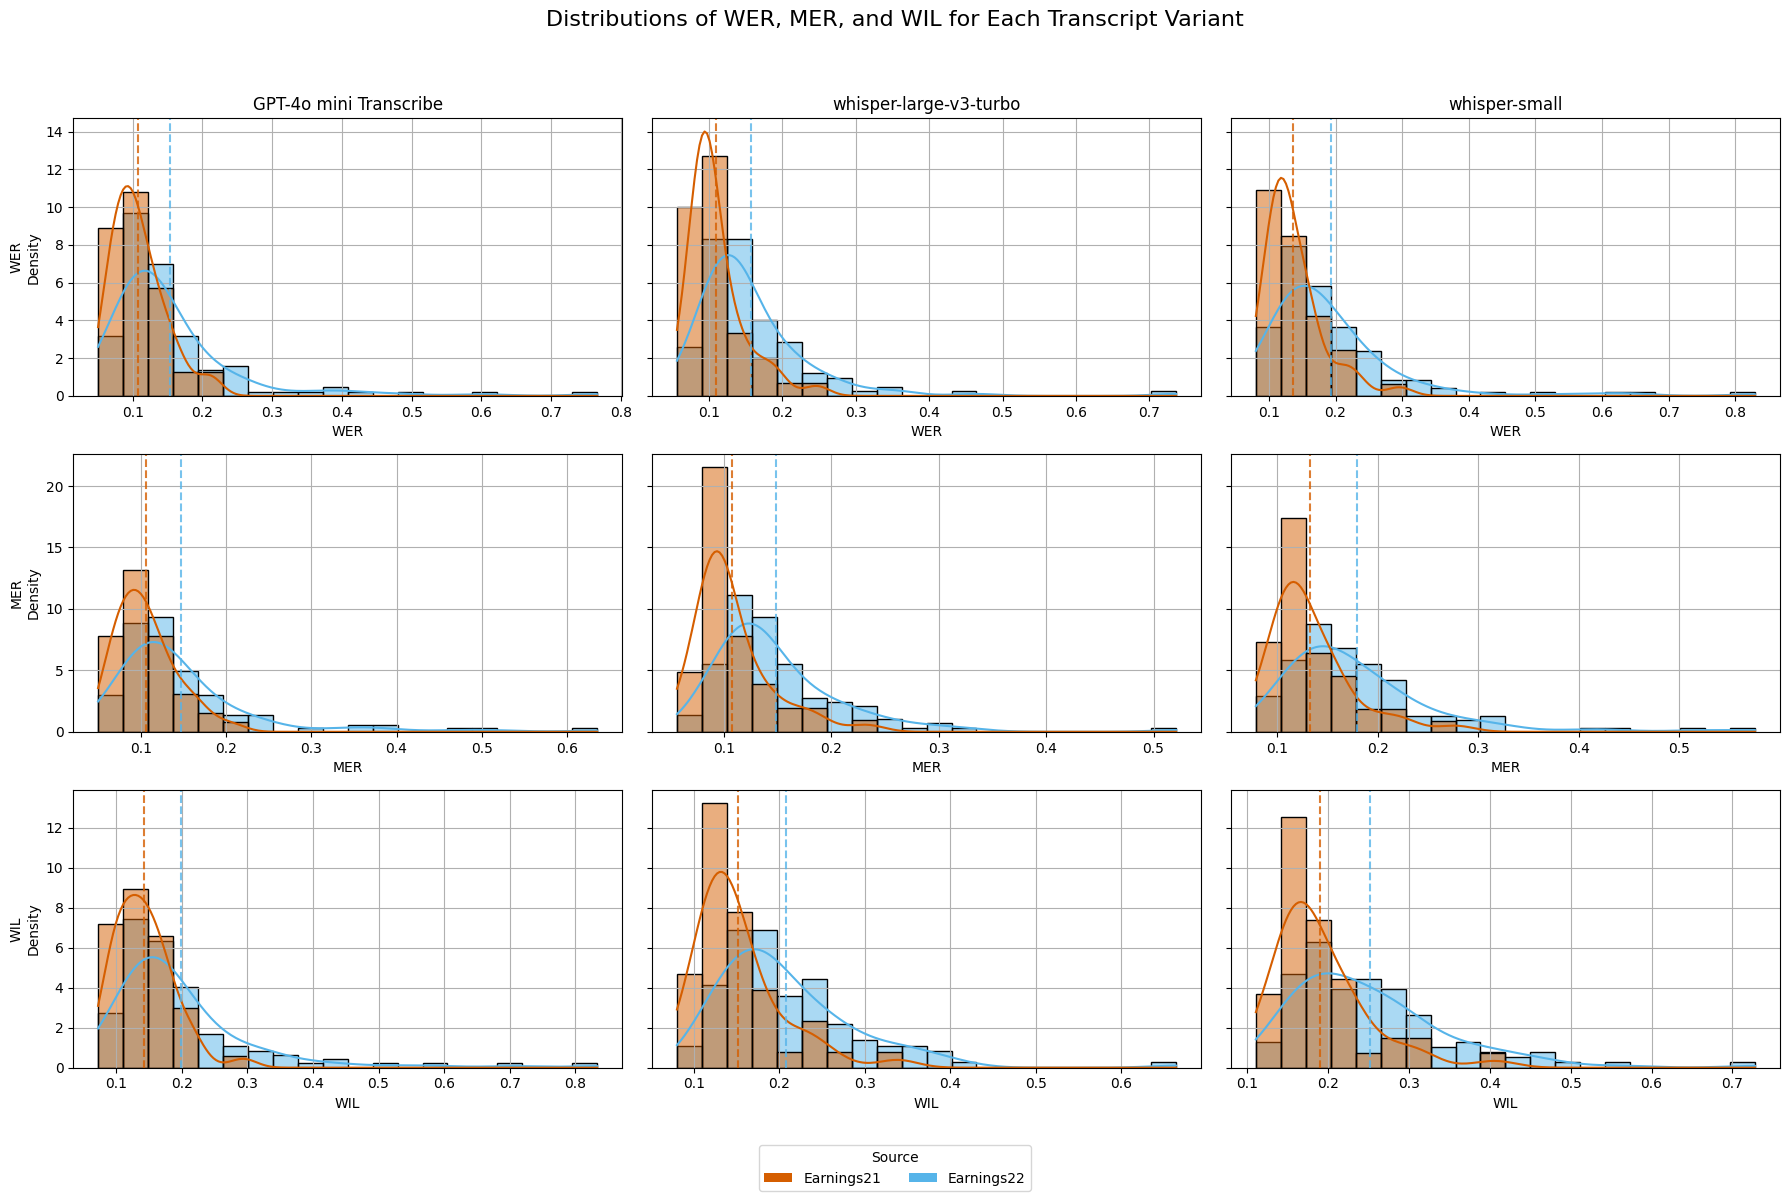

In [92]:
# Add 'source' column and combine
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'
df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Melt for boxplot
df_melted = df_combined.melt(
    id_vars=['folder', 'source', 'variant'],
    value_vars=['wer', 'mer', 'wil'],
    var_name='metric',
    value_name='value'
)

palette = {
    "combined_21": "#D55E00",
    "combined_22": "#56B4E9"
}

legend_label_map = {
    "combined_21": "Earnings21",
    "combined_22": "Earnings22"
}

variants = sorted(df_combined['variant'].unique())
metrics = ['wer', 'mer', 'wil']

# === Combined 3x3 figure ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey='row')

for row, metric in enumerate(metrics):
    print(f"\n=== {metric.upper()} Means by Variant and Source ===")

    for col, variant in enumerate(variants):
        ax = axes[row][col]
        df_variant = df_combined[df_combined['variant'] == variant]

        # Histogram with KDE
        sns.histplot(
            data=df_variant,
            x=metric,
            hue='source',
            palette=palette,
            kde=True,
            bins=20,
            stat='density',
            common_norm=False,
            ax=ax,
            legend=False
        )

        # Add vertical mean lines and print
        for source in df_variant['source'].unique():
            source_df = df_variant[df_variant['source'] == source]
            mean_val = source_df[metric].mean()
            color = palette[source]

            # Print to console
            print(f"{variant:30} | {legend_label_map[source]:12} → Mean {metric.upper()}: {mean_val:.3f}")

            ax.axvline(mean_val, linestyle='--', color=color, linewidth=1.5, alpha=0.8)

        # Titles and labels
        if row == 0:
            ax.set_title(f"{variant}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{metric.upper()}\nDensity", fontsize=10)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(metric.upper())
        ax.grid(True)

# === Add shared legend with renamed labels ===
legend_elements = [
    Patch(facecolor=palette["combined_21"], label="Earnings21"),
    Patch(facecolor=palette["combined_22"], label="Earnings22")
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.01),
    frameon=True,
    title="Source"
)

fig.suptitle("Distributions of WER, MER, and WIL for Each Transcript Variant", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

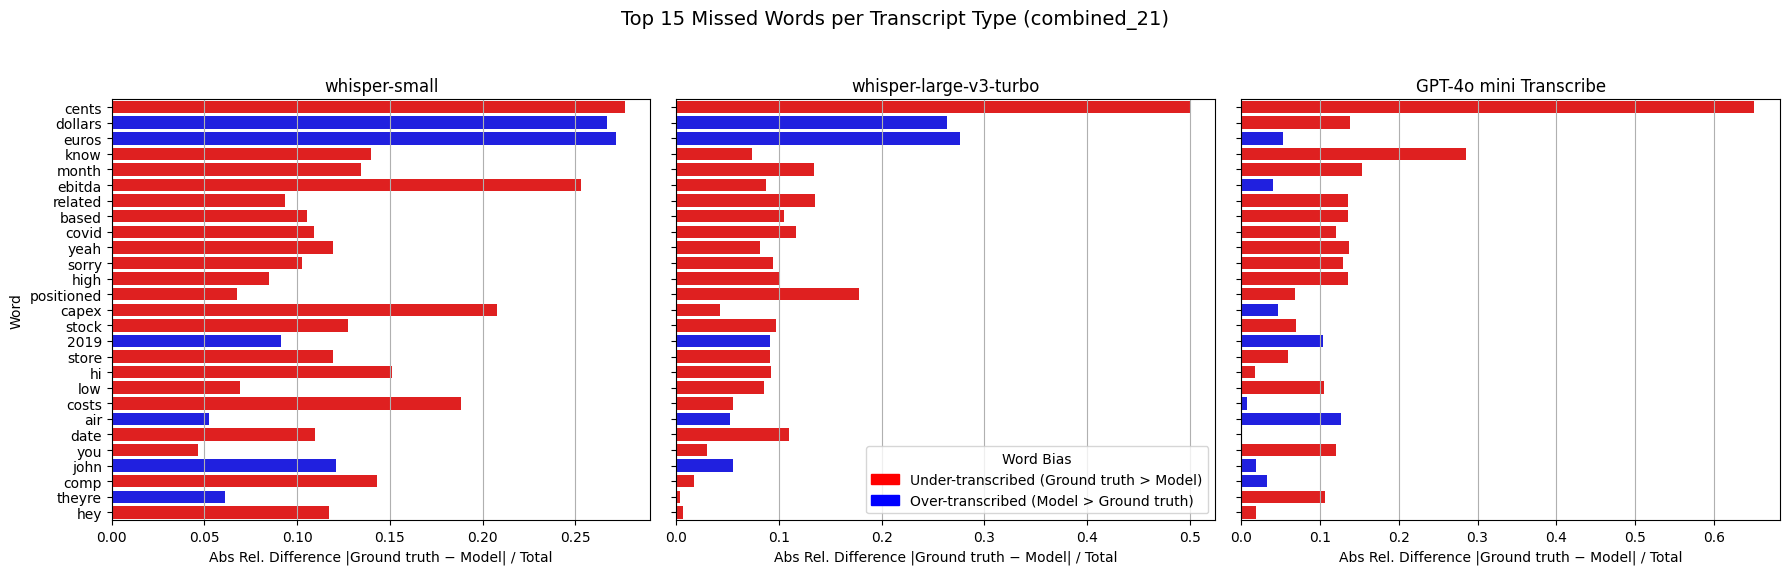

C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\Niller\AppData\Local\Temp\ipykernel_4832\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

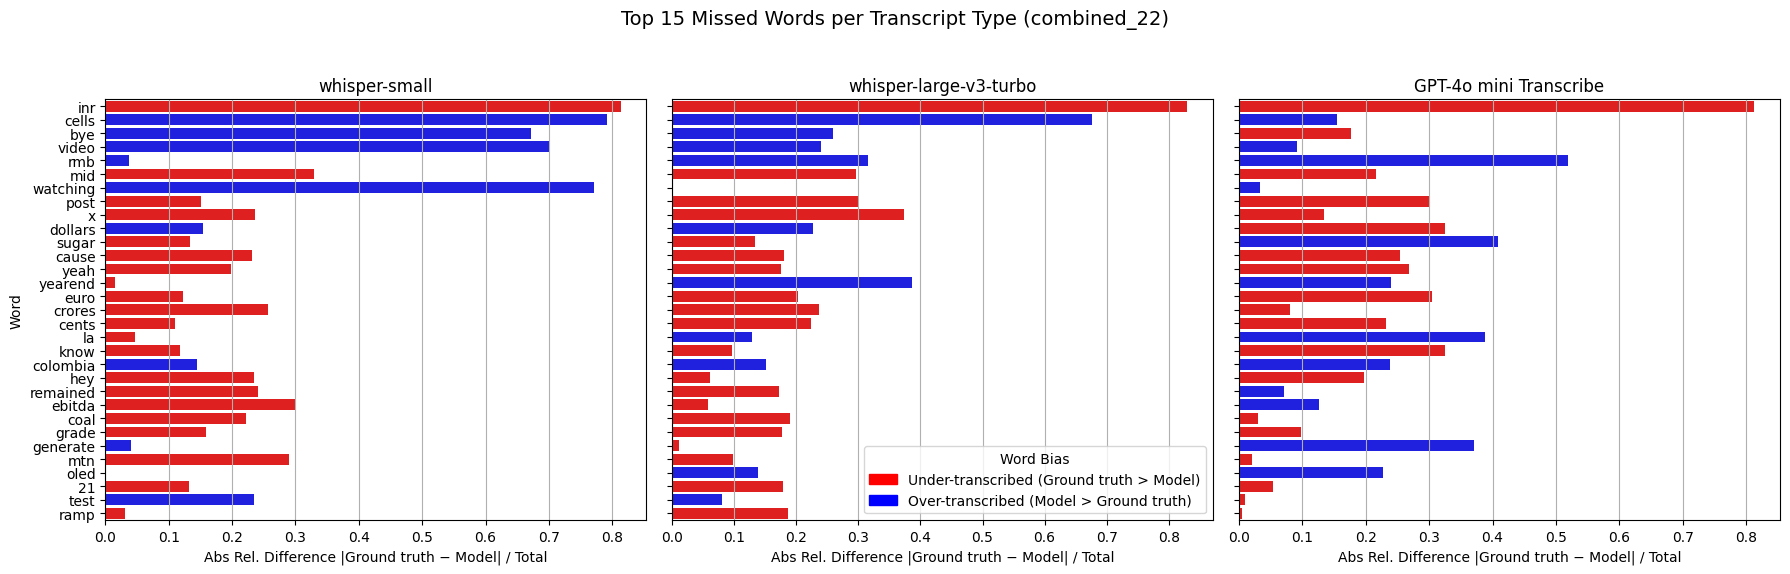

In [80]:
min_total = 100
def get_top_missed_words_by_variant(df_paths, label='', top_n=15, plot=True, filter_words=None):
    variants = df_paths['variant'].unique()
    fig, axes = plt.subplots(1, len(variants), figsize=(6 * len(variants), 6), sharey=True) if plot else (None, [None] * len(variants))
    if len(variants) == 1:
        axes = [axes]  

    all_top_words = []
    for i, (ax, variant) in enumerate(zip(axes, variants)):
        df_var = df_paths[df_paths['variant'] == variant]
        gt_words = []
        hyp_words = []

        for _, row in df_var.iterrows():
            gt_words += row['gt_text'].split()
            hyp_words += row['hyp_text'].split()

        gt_counter = Counter(gt_words)
        hyp_counter = Counter(hyp_words)
        all_words = set(gt_counter) | set(hyp_counter)

        data = []
        for word in all_words:
            gt_count = gt_counter[word]
            hyp_count = hyp_counter[word]
            total = gt_count + hyp_count
            color = 'red' if gt_count > hyp_count else 'blue'
            rel_diff = abs((gt_count - hyp_count)) / total
            data.append({
                'variant': variant,
                'word': word,
                'gt_count': gt_count,
                'hyp_count': hyp_count,
                'rel_diff': rel_diff,
                'total': total,
                'top' : False,
                'color': color
            })

        df_diff = pd.DataFrame(data)
        df_top = df_diff[df_diff['total'] > min_total].sort_values(by='rel_diff', ascending=False).head(top_n)
        df_diff['top'] = df_diff['word'].isin(df_top['word'])
        all_top_words.append(df_diff)
        if plot:
            if filter_words is not None:
                df_plot = df_diff[df_diff['word'].isin(filter_words)]
            else:
                df_plot = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)
            sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
            if i == 1:  # Only show legend on the middle plot
                legend_handles = [Patch(color='red', label='Under-transcribed (Ground truth > Model)'), Patch(color='blue', label='Over-transcribed (Model > Ground truth)')]
                ax.legend(handles=legend_handles, title='Word Bias', loc='lower right')
            ax.set_title(f"{variant}")
            ax.set_xlabel("Abs Rel. Difference |Ground truth − Model| / Total")
            ax.set_ylabel("Word")
            ax.grid(True, axis='x')

    if plot:
        plt.suptitle(f"Top {top_n} Missed Words per Transcript Type ({label})", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    return pd.concat(all_top_words, ignore_index=True)




# First run: collect all data (no plots)
df_all_21 = get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=False)
df_all_22 = get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=False)

top_words_21 = df_all_21[(df_all_21['total'] > min_total) & (df_all_21['top'])]['word'].unique()
top_words_22 = df_all_22[(df_all_22['total'] > min_total) & (df_all_22['top'])]['word'].unique()

ordered_words_21 = (
    df_all_21[df_all_21['word'].isin(top_words_21)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_22 = (
    df_all_22[df_all_22['word'].isin(top_words_22)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_21 = ordered_words_21['word'].tolist()
ordered_words_22 = ordered_words_22['word'].tolist()

get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=True, filter_words=ordered_words_21)
get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=True, filter_words=ordered_words_22)


In [81]:
def extract_numbers(text):
    return re.findall(r'\d+(?:\.\d+)?', text)

def count_aligned_numbers(gt_numbers, hyp_numbers):
    matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
    return sum(block.size for block in matcher.get_matching_blocks() if block.size > 0)


def normalize_number(n):
    if '.' in n:
        return str(float(n))  # e.g. 2.40 = 2.4
    return n

def evaluate_number_accuracy(df_paths):
    results = []
    variants = df_paths['variant'].unique()

    for variant in variants:
        df_var = df_paths[df_paths['variant'] == variant]

        gt_total = 0
        pred_total = 0
        correct_total = 0

        for _, row in df_var.iterrows():
            gt_numbers = [normalize_number(n) for n in extract_numbers(row['gt_text'])]
            hyp_numbers = [normalize_number(n) for n in extract_numbers(row['hyp_text'])]
            gt_total += len(gt_numbers)
            pred_total += len(hyp_numbers)
            correct_total += count_aligned_numbers(gt_numbers, hyp_numbers)

        precision = correct_total / pred_total #Out of all the positive predictions we made, how many were true?
        recall = correct_total / gt_total #Out of all the data points that should be predicted as true, how many did we correctly predict as true?
        f1 = 2 * precision * recall / (precision + recall)

        results.append({
            'variant': variant,
            'gt_total': gt_total,
            'pred_total': pred_total,
            'correct': correct_total,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    # Compute overall totals
    totals = pd.DataFrame(results).sum(numeric_only=True)
    total_correct = totals['correct']
    total_pred = totals['pred_total']
    total_gt = totals['gt_total']
    total_precision = total_correct / total_pred if total_pred else 0
    total_recall = total_correct / total_gt if total_gt else 0
    total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall) if (total_precision + total_recall) else 0

    results.append({
        'variant': 'TOTAL',
        'gt_total': total_gt,
        'pred_total': total_pred,
        'correct': total_correct,
        'precision': total_precision,
        'recall': total_recall,
        'f1': total_f1
    })

    df_result = pd.DataFrame(results)
    print(df_result.to_string(index=False, float_format='%.3f'))
    return df_result

print("Number accuracy for combined_21:")
evaluate_number_accuracy(df_paths_21)
print("\nNumber accuracy for combined_22:")
evaluate_number_accuracy(df_paths_22)


Number accuracy for combined_21:
               variant  gt_total  pred_total   correct  precision  recall    f1
         whisper-small  9518.000    9479.000  8014.000      0.845   0.842 0.844
whisper-large-v3-turbo  9518.000    9499.000  8153.000      0.858   0.857 0.857
GPT-4o mini Transcribe  9518.000    9389.000  8171.000      0.870   0.858 0.864
                 TOTAL 28554.000   28367.000 24338.000      0.858   0.852 0.855

Number accuracy for combined_22:
               variant  gt_total  pred_total   correct  precision  recall    f1
         whisper-small 31340.000   31134.000 24572.000      0.789   0.784 0.787
whisper-large-v3-turbo 31340.000   30983.000 25722.000      0.830   0.821 0.825
GPT-4o mini Transcribe 31340.000   30807.000 26629.000      0.864   0.850 0.857
                 TOTAL 94020.000   92924.000 76923.000      0.828   0.818 0.823


,variant,gt_total,pred_total,correct,precision,recall,f1
0,whisper-small,31340.0,31134.0,24572.0,0.789234,0.784046,0.786631
1,whisper-large-v3-turbo,31340.0,30983.0,25722.0,0.830197,0.820740,0.825442
2,GPT-4o mini Transcribe,31340.0,30807.0,26629.0,0.864381,0.849681,0.856968
3,TOTAL,94020.0,92924.0,76923.0,0.827806,0.818156,0.822952


In [82]:
#Only measuring numbers in financial context

financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
     'annual', 'fiscal', 'monthly'
}

def extract_contextual_numbers(text, window=10):
    words = text.lower().split()
    numbers = []
    for idx, word in enumerate(words):
        if re.fullmatch(r'\d+(?:\.\d+)?', word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                numbers.append(word)
    return numbers

def count_aligned_numbers(gt_numbers, hyp_numbers):
    matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
    return sum(block.size for block in matcher.get_matching_blocks() if block.size > 0)

def evaluate_contextual_number_accuracy(df_paths):
    results = []
    variants = df_paths['variant'].unique()

    for variant in variants:
        df_var = df_paths[df_paths['variant'] == variant]

        gt_total = 0
        pred_total = 0
        correct_total = 0

        for _, row in df_var.iterrows():
            gt_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['gt_text'])]
            hyp_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['hyp_text'])]

            gt_total += len(gt_numbers)
            pred_total += len(hyp_numbers)
            correct_total += count_aligned_numbers(gt_numbers, hyp_numbers)

        precision = correct_total / pred_total  #Out of all the positive predictions we made, how many were true? 
        recall = correct_total / gt_total #Out of all the data points that should be predicted as true, how many did we correctly predict as true?
        f1 = 2 * precision * recall / (precision + recall) 

        results.append({
            'variant': variant,
            'gt_total': gt_total,
            'pred_total': pred_total,
            'correct': correct_total,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    totals = pd.DataFrame(results).sum(numeric_only=True)
    total_correct = totals['correct']
    total_pred = totals['pred_total']
    total_gt = totals['gt_total']
    total_precision = total_correct / total_pred if total_pred else 0
    total_recall = total_correct / total_gt if total_gt else 0
    total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall) if (total_precision + total_recall) else 0

    results.append({
        'variant': 'TOTAL',
        'gt_total': total_gt,
        'pred_total': total_pred,
        'correct': total_correct,
        'precision': total_precision,
        'recall': total_recall,
        'f1': total_f1
    })

    df_result = pd.DataFrame(results)
    print(df_result.to_string(index=False, float_format='%.3f'))
    return df_result
print("Number accuracy for combined_21:")
evaluate_contextual_number_accuracy(df_paths_21)
print("\nNumber accuracy for combined_22:")
evaluate_contextual_number_accuracy(df_paths_22)

Number accuracy for combined_21:
               variant  gt_total  pred_total  correct  precision  recall    f1
         whisper-small  2441.000    2391.000 2039.000      0.853   0.835 0.844
whisper-large-v3-turbo  2441.000    2403.000 2105.000      0.876   0.862 0.869
GPT-4o mini Transcribe  2441.000    2418.000 2137.000      0.884   0.875 0.880
                 TOTAL  7323.000    7212.000 6281.000      0.871   0.858 0.864

Number accuracy for combined_22:
               variant  gt_total  pred_total   correct  precision  recall    f1
         whisper-small  7526.000    7038.000  5750.000      0.817   0.764 0.790
whisper-large-v3-turbo  7526.000    7161.000  6053.000      0.845   0.804 0.824
GPT-4o mini Transcribe  7526.000    7331.000  6278.000      0.856   0.834 0.845
                 TOTAL 22578.000   21530.000 18081.000      0.840   0.801 0.820


,variant,gt_total,pred_total,correct,precision,recall,f1
0,whisper-small,7526.0,7038.0,5750.0,0.816993,0.764018,0.789618
1,whisper-large-v3-turbo,7526.0,7161.0,6053.0,0.845273,0.804279,0.824266
2,GPT-4o mini Transcribe,7526.0,7331.0,6278.0,0.856363,0.834175,0.845124
3,TOTAL,22578.0,21530.0,18081.0,0.839805,0.800824,0.819851


In [101]:
test_1 = [1,2,3,4,1,2,3]
test_2 = [1,2,3,1,2,3,4]
matcher = SequenceMatcher(None, test_1, test_2)
print(matcher.get_matching_blocks()) # Should return 6

[Match(a=0, b=3, size=4), Match(a=7, b=7, size=0)]


In [93]:
#Quick fix: adding the num error to df_22


# --- Financial keyword setup ---
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

def extract_contextual_numbers(text, window=10):
    words = text.lower().split()
    numbers = []
    for idx, word in enumerate(words):
        if re.fullmatch(r'\d+(?:\.\d+)?', word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                numbers.append(word)
    return numbers

def normalize_number(n):
    return str(float(n)).rstrip('0').rstrip('.') if '.' in n else str(int(n))

def count_aligned_numbers(gt_numbers, hyp_numbers):
    matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
    return sum(block.size for block in matcher.get_matching_blocks() if block.size > 0)

# --- Compute per-row numerical error ---
numerical_errors = []

for _, row in df_paths_22.iterrows():
    gt_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['gt_text'])]
    hyp_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['hyp_text'])]

    gt_total = len(gt_numbers)
    pred_total = len(hyp_numbers)
    correct = count_aligned_numbers(gt_numbers, hyp_numbers)

    precision = correct / pred_total if pred_total else 0
    recall = correct / gt_total if gt_total else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    numerical_errors.append({
        "folder": row["folder"],
        "variant": row["variant"],
        "numerical_error": 1 - f1
    })

# --- Merge result into df_22 ---
df_num_error = pd.DataFrame(numerical_errors)
df_22 = df_22.merge(df_num_error, on=["folder", "variant"], how="left")


In [94]:
metadata = pd.read_csv("metadata_22.csv")
metadata = metadata.rename(columns={"File ID": "folder"})

df_22 = df_22.merge(metadata[["folder", "Language Family + Area Based"]], on="folder", how="left")
df_22 = df_22.rename(columns={"Language Family + Area Based": "Language Family"})


In [95]:
print(df_22.head(20))

                                               folder                 variant  \
0   2020-03-0230487MTN-Ghana-2019-Annual-Results-Call           whisper-small   
1   2020-03-0230487MTN-Ghana-2019-Annual-Results-Call  whisper-large-v3-turbo   
2   2020-03-0230487MTN-Ghana-2019-Annual-Results-Call  GPT-4o mini Transcribe   
3                  2020-Annual-Results-Call-Recording           whisper-small   
4                  2020-Annual-Results-Call-Recording  whisper-large-v3-turbo   
5                  2020-Annual-Results-Call-Recording  GPT-4o mini Transcribe   
6                                             4329526           whisper-small   
7                                             4329526  whisper-large-v3-turbo   
8                                             4329526  GPT-4o mini Transcribe   
9                                             4351517           whisper-small   
10                                            4351517  whisper-large-v3-turbo   
11                          


📊 Evaluating for Language Family: African
               variant  gt_total  pred_total  correct  precision  recall    f1
         whisper-small   711.000     636.000  558.000      0.877   0.785 0.829
whisper-large-v3-turbo   711.000     678.000  579.000      0.854   0.814 0.834
GPT-4o mini Transcribe   711.000     720.000  615.000      0.854   0.865 0.860
                 TOTAL  2133.000    2034.000 1752.000      0.861   0.821 0.841

📊 Evaluating for Language Family: Spanish/Portuguese
               variant  gt_total  pred_total   correct  precision  recall    f1
         whisper-small  5322.000    4722.000  3903.000      0.827   0.733 0.777
whisper-large-v3-turbo  5322.000    4947.000  4227.000      0.854   0.794 0.823
GPT-4o mini Transcribe  5322.000    5124.000  4380.000      0.855   0.823 0.839
                 TOTAL 15966.000   14793.000 12510.000      0.846   0.784 0.813

📊 Evaluating for Language Family: Asian
               variant  gt_total  pred_total  correct  precision  r

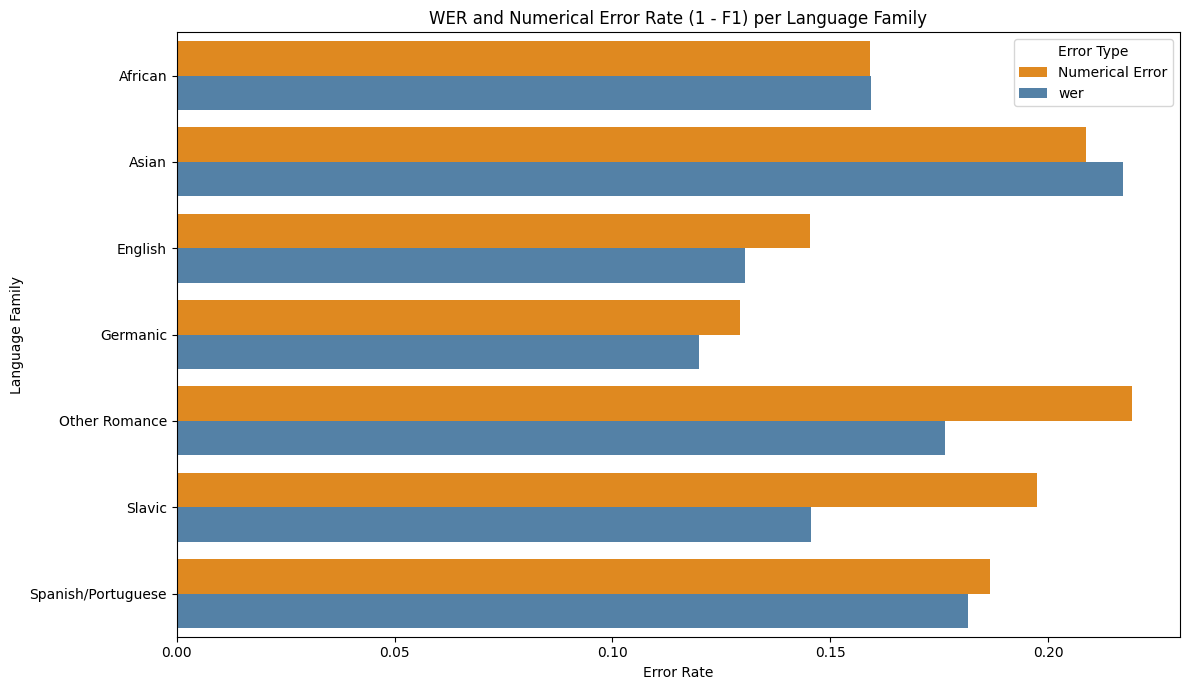

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [86]:
# Merge language family into df_paths_22
df_paths_22 = df_paths_22.merge(df_22[["folder", "Language Family"]], on="folder", how="left")

# Store per-family evaluation results
all_results = []

# Loop through each family and evaluate
for family in df_paths_22["Language Family"].dropna().unique():
    df_subset = df_paths_22[df_paths_22["Language Family"] == family].copy()
    print(f"\n📊 Evaluating for Language Family: {family}")
    
    result = evaluate_contextual_number_accuracy(df_subset)
    result["Language Family"] = family
    all_results.append(result)

# Combine results
df_family_results = pd.concat(all_results, ignore_index=True)

# Filter only total rows
df_totals = df_family_results[df_family_results["variant"] == "TOTAL"]

# Merge in WER from df_22
wer_means = df_22.groupby("Language Family")["wer"].mean().reset_index()
df_plot = df_totals.merge(wer_means, on="Language Family")

df_plot["Numerical Error"] = 1 - df_plot["f1"]

# Melt the DataFrame to long format for Seaborn
df_long = df_plot.melt(
    id_vars="Language Family",
    value_vars=["wer", "Numerical Error"],
    var_name="Error Type",
    value_name="Error Rate"
)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_long.sort_values(["Language Family", "Error Type"]),
    x="Error Rate",
    y="Language Family",
    hue="Error Type",
    palette={"wer": "steelblue", "Numerical Error": "darkorange"}
)

plt.title("WER and Numerical Error Rate (1 - F1) per Language Family")
plt.xlabel("Error Rate")
plt.ylabel("Language Family")
plt.legend(title="Error Type")
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 6))



In [96]:
from scipy.stats import f_oneway

# Ensure there are no missing values in the grouping variable
df_anova = df_22.dropna(subset=["Language Family"])

# Group WER by language family
groups_wer = [
    group["wer"].values
    for _, group in df_anova.groupby("Language Family")
]

# Run ANOVA for WER
f_stat_wer, p_value_wer = f_oneway(*groups_wer)
print(f"WER ANOVA — F-statistic: {f_stat_wer:.3f}, p-value: {p_value_wer:.4f}")

# Group numerical error by language family
groups_num = [
    group["numerical_error"].values
    for _, group in df_anova.groupby("Language Family")
]

# Run ANOVA for Numerical Error
f_stat_num, p_value_num = f_oneway(*groups_num)
print(f"Numerical Error ANOVA — F-statistic: {f_stat_num:.3f}, p-value: {p_value_num:.4f}")


WER ANOVA — F-statistic: 8.187, p-value: 0.0000
Numerical Error ANOVA — F-statistic: 5.106, p-value: 0.0000


**LONG RUNNING TIME BLOCKS**

Making lists of examples:

In [ ]:
import pandas as pd
import random
import re
from collections import defaultdict
from rapidfuzz import process, fuzz

# Seed for reproducibility
random.seed(42)

# Combine top word lists
top_words = list(set(ordered_words_21 + ordered_words_22))

# Parameters
chunk_size = 20
window_range = 300
sample_limit = 30

# Store results
context_examples = {word: [] for word in top_words}

datasets = [("combined_21", df_paths_21), ("combined_22", df_paths_22)]

for label, df_paths in datasets:
    for _, row in df_paths.iterrows():
        gt_text = row['gt_text'].lower()
        whisper_text = row['hyp_text'].lower()  # Assuming this column is the model output

        gt_words = re.findall(r'\b\w+\b', gt_text)
        whisper_words = re.findall(r'\b\w+\b', whisper_text)

        whisper_snippets = [
            ' '.join(whisper_words[i:i + chunk_size])
            for i in range(len(whisper_words) - chunk_size + 1)
        ]

        # Index locations of top words in GT
        word_indices = defaultdict(list)
        for i, token in enumerate(gt_words):
            if token in top_words:
                word_indices[token].append(i)

        for token, indices in word_indices.items():
            sampled_indices = random.sample(indices, min(sample_limit, len(indices)))
            for i in sampled_indices:
                start = max(i - 10, 0)
                end = min(i + 11, len(gt_words))
                gt_snippet = ' '.join(gt_words[start:end])

                # Estimate where to look in hypothesis
                approx_chunk = int(i * len(whisper_snippets) / len(gt_words))
                chunk_start = max(approx_chunk - window_range, 0)
                chunk_end = min(approx_chunk + window_range + 1, len(whisper_snippets))
                local_snippets = whisper_snippets[chunk_start:chunk_end]

                best_match, score, _ = process.extractOne(
                    gt_snippet, local_snippets, scorer=fuzz.partial_ratio
                )

                whisper_match = best_match if best_match else '[No match found]'
                whisper_start_index = (
                    chunk_start + local_snippets.index(best_match)
                    if best_match in local_snippets else -1
                )

                context_examples[token].append({
                    'word': token,
                    'gt_snippet': gt_snippet,
                    'gt_index': i,
                    'whisper_snippet': whisper_match,
                    'whisper_index': whisper_start_index,
                    'score': score,
                    'dataset': label,
                    'folder': row['folder']
                })

# Flatten and save as CSV
rows = [example for word_examples in context_examples.values() for example in word_examples]
df_context = pd.DataFrame(rows)
df_context.to_csv('top_word_context_examples.csv', index=False)
print(f"Saved {len(df_context)} examples to 'top_word_context_examples.csv'")


NameError: name 'ordered_words_21' is not defined

In [ ]:
rows = []

for word, examples in context_examples.items():
    for ex in examples:
        rows.append({
            "word": word,
            "gt_snippet": ex['gt_snippet'],
            "whisper_snippet": ex['whisper_snippet'],
            "gt_index": ex['gt_index'],
            "whisper_index": ex['whisper_index'],
            "score": ex['score'],
            "folder": ex['folder'],
            "dataset": ex['dataset']
        })

df_matches = pd.DataFrame(rows)
df_matches.to_csv("gt_whisper_matches.csv", index=False)


Number exploration

In [13]:
import pandas as pd
import random
import re
from collections import defaultdict
from rapidfuzz import process, fuzz

# Reproducibility
random.seed(42)

# Parameters
chunk_size = 20
window_range = 300
sample_limit = 30
score_threshold = 70  # Only include matches with score ≥ 70

# Pattern for detecting numbers
number_pattern = r'\d+(?:\.\d+)?'

# Where to store results
examples = {
    'not_transcribed_as_number': [],
    'incorrect_number_transcription': []
}

# Loop through datasets
datasets = [("combined_21", df_paths_21), ("combined_22", df_paths_22)]

for label, df_paths in datasets:
    for _, row in df_paths.iterrows():
        gt_text = row['gt_text']
        hyp_text = row['hyp_text']
        variant = row['variant']

        token_pattern = r'\d+\.\d+|\w+'
        gt_words = re.findall(token_pattern, gt_text)
        hyp_words = re.findall(token_pattern, hyp_text)

        # Create rolling hypothesis snippets
        hyp_snippets = [
            ' '.join(hyp_words[i:i + chunk_size])
            for i in range(len(hyp_words) - chunk_size + 1)
        ]

        # Find all numbers in GT and their positions
        gt_number_indices = [(i, word) for i, word in enumerate(gt_words) if re.fullmatch(number_pattern, word)]

        # Sample some numbers for inspection
        sampled = random.sample(gt_number_indices, min(sample_limit, len(gt_number_indices)))

        for i, number in sampled:
            # Get GT context
            start = max(i - 10, 0)
            end = min(i + 11, len(gt_words))
            gt_snippet = ' '.join(gt_words[start:end])

            # Approximate matching region in hypothesis
            approx_chunk = int(i * len(hyp_snippets) / len(gt_words))
            chunk_start = max(approx_chunk - window_range, 0)
            chunk_end = min(approx_chunk + window_range + 1, len(hyp_snippets))
            local_snippets = hyp_snippets[chunk_start:chunk_end]

            # Fuzzy match
            best_match, score, _ = process.extractOne(gt_snippet, local_snippets, scorer=fuzz.partial_ratio)
            hyp_snippet = best_match if best_match else '[No match found]'

            if best_match and score >= score_threshold:
                if not re.search(number, hyp_snippet):
                    if not re.search(r'\d', hyp_snippet):
                        # Case (a): number not transcribed at all
                        examples['not_transcribed_as_number'].append({
                            'number': number,
                            'gt_snippet': gt_snippet,
                            'whisper_snippet': hyp_snippet,
                            'type': 'missing',
                            'variant': variant,
                            'score': score,
                            'dataset': label,
                            'folder': row['folder']
                        })
                    else:
                        # Case (b): number incorrectly transcribed
                        hyp_numbers = re.findall(number_pattern, hyp_snippet)
                        if number not in hyp_numbers:
                            examples['incorrect_number_transcription'].append({
                                'number': number,
                                'gt_snippet': gt_snippet,
                                'whisper_snippet': hyp_snippet,
                                'type': 'wrong',
                                'variant': variant,
                                'score': score,
                                'dataset': label,
                                'folder': row['folder']
                            })

# Save to CSV
for error_type, data in examples.items():
    df = pd.DataFrame(data)
    filename = f'{error_type}_examples.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {len(df)} examples to '{filename}'")


Saved 179 examples to 'not_transcribed_as_number_examples.csv'
Saved 612 examples to 'incorrect_number_transcription_examples.csv'
